# Algorithm Implementation: Random Forests

## Overview
Implementation of Random Forests to predict and analyze GHG emissions per capita using an ensemble of decision trees. This approach provides robust predictions and insights into the relationships between economic development, military expenditure, and environmental impact.

## Objectives
- Predict GHG emissions per capita from development indicators
- Identify key drivers of environmental impact
- Analyze feature interactions and importance
- Assess military expenditure's role in emissions
- Provide robust policy recommendations

## Key Questions
1. What combination of development indicators best predicts GHG emissions?
2. How does military expenditure influence environmental impact?
3. What are the relative importances of economic vs. social factors?
4. Are there interaction effects between development indicators?

In [1]:
import wbdata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

plt.style.use('seaborn-v0_8-white')
sns.set_context('talk', font_scale=0.9)
sns.set_palette(['#1f77b4', '#ff7f0e'])  

Key '3859496880217065728' not in persistent cache.
Key '6670500267734351695' not in persistent cache.
Key '7378566394764949997' not in persistent cache.
Key '-8257174291427315652' not in persistent cache.
Key '1357375960716269510' not in persistent cache.
Key '4622208062714827816' not in persistent cache.
Key '-9104855756914175060' not in persistent cache.
Key '-5217385575563934014' not in persistent cache.
Key '4614142607024450091' not in persistent cache.
Key '7878974709023008397' not in persistent cache.
Key '-766732033480692770' not in persistent cache.
Key '8057611767727823010' not in persistent cache.
Key '3913491797292780845' not in persistent cache.
Key '7178323899291339151' not in persistent cache.
Key '-1522144843357454484' not in persistent cache.
Key '8763212053712201960' not in persistent cache.
Key '-8975465892966751354' not in persistent cache.
Key '-6164462505449465387' not in persistent cache.
Key '8519251774604559185' not in persistent cache.
Key '-7116488911587706464

## Data Collection and Preprocessing

### 1. Data Collection
We'll fetch data from the World Bank's World Development Indicators database using the `wbdata` package.

### Implementation

- **Data Fetching**: Use `wbdata` to retrieve 2020 indicators:
    - GDP per capita (`NY.GDP.PCAP.KD`)
    - Life Expectancy (`SP.DYN.LE00.IN`)
    - CO2 Emissions per Capita (`EN.GHG.ALL.MT.CE.AR5`)
    - Labor Force Participation (`SL.TLF.CACT.ZS`)
    - Military Expenditure (`MS.MIL.XPND.GD.ZS`)
    - Region and Income Group


- **Data Storage**: Save raw data as a CSV file for reproducibility and future reference.

- **Summary**: Include a markdown summary of the fetched data (e.g., "Fetched 200+ countries’ indicators").

In [3]:
def fetch_world_bank_data():
    """Fetch World Bank indicators with country metadata."""
    # Get country metadata first
    countries = wbdata.get_countries()
    country_metadata = {
        c['name']: {
            'region': c.get('region', {}).get('value', 'Unknown'),
            'income': c.get('incomeLevel', {}).get('value', 'Unknown'),
            'iso3': c['id']
        }
        for c in countries
    }

    # Define indicators
    indicators = {
        'NY.GDP.PCAP.KD': 'GDP per capita',
        'SP.DYN.LE00.IN': 'Life Expectancy',
        'EN.GHG.ALL.MT.CE.AR5': 'CO2 Emissions per Capita',
        'SL.TLF.CACT.ZS': 'Labor Force Participation',
        'MS.MIL.XPND.GD.ZS': 'Military Expenditure'
    }

    try:
        # Fetch data with country names as index
        df = wbdata.get_dataframe(indicators, country='all', date='2020')
        df = df.reset_index()
        
        # Add metadata using country name matching
        df['Region'] = df['country'].map(lambda x: country_metadata.get(x, {}).get('region', 'Unknown'))
        df['Income Group'] = df['country'].map(lambda x: country_metadata.get(x, {}).get('income', 'Unknown'))
        df['ISO3'] = df['country'].map(lambda x: country_metadata.get(x, {}).get('iso3', 'Unknown'))
        
        # Clean data
        df = df[df['Region'] != 'Aggregates']
        df = df.rename(columns={'country': 'Country'})
        df = df.dropna(subset=['Country'])
        
        print(f"Fetched {df.shape[0]} countries")
        return df[['ISO3', 'Country', 'Region', 'Income Group'] + list(indicators.values())]
    
    except Exception as e:
        print(f"Error: {e}")
        raise SystemExit("Check indicator codes or use cached data.")

# Usage
df = fetch_world_bank_data()
df.to_csv('raw_emissions_data.csv', index=False)
display(df.head())

Fetched 219 countries


,ISO3,Country,Region,Income Group,GDP per capita,Life Expectancy,CO2 Emissions per Capita,Labor Force Participation,Military Expenditure
23,Unknown,Latin America & Caribbean,Unknown,Unknown,8145.999677,73.188934,3230.6888,59.587555,1.293406
44,Unknown,Sub-Saharan Africa,Unknown,Unknown,1532.695576,61.167527,2288.2718,68.095027,1.040761
49,AFG,Afghanistan,South Asia,Low income,527.834554,61.454000,26.6463,41.579000,1.358857
50,ALB,Albania,Europe & Central Asia,Upper middle income,4417.041051,77.824000,7.9674,57.780000,1.295836
51,DZA,Algeria,Middle East & North Africa,Upper middle income,4363.685338,73.257000,241.1320,39.552000,6.658711


### 2. Data Preprocessing
We'll prepare the data for random forest analysis, focusing on feature engineering and handling missing values.

### Implementation

- **Define Features**:
    - `numeric_features`: Examples include `['GDP per capita', 'Life Expectancy', ...]`.
    - `categorical_features`: Examples include `['Region', 'Income Group']`.

- **Data Cleaning**:
    - Impute missing values:
        - Use group means (by `Income Group`) for numeric features.
        - Use mode for categorical features.
    - Clip outliers using the IQR (1.5x rule).

- **Feature Engineering**:
    - Log-transform `GDP per capita` and `CO2 Emissions per Capita` for normality.
    - Create new features:
        - `Military to GDP ratio`.
        - `Development Status` (binary, based on GDP median).
    - One-hot encode categorical features (`Region`, `Income Group`).

In [4]:
def preprocess_data(df):
    """Preprocess World Bank data for Random Forest."""
    # Define features
    numeric_features = ['GDP per capita', 'Life Expectancy', 'CO2 Emissions per Capita',
                        'Labor Force Participation', 'Military Expenditure']
    categorical_features = ['Region', 'Income Group']
    
    # Impute missing values
    for col in numeric_features:
        df[col] = df.groupby('Income Group')[col].transform(lambda x: x.fillna(x.mean()))
        df[col] = df[col].fillna(df[col].mean())
    for col in categorical_features:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # Feature engineering
    df['Log CO2 Emissions per Capita'] = np.log1p(df['CO2 Emissions per Capita'].clip(lower=0))
    df['Log GDP per capita'] = np.log1p(df['GDP per capita'].clip(lower=1e-10))
    df['Military to GDP ratio'] = df['Military Expenditure'] / df['GDP per capita'].replace(0, 1e-10)
    df['Development Status'] = (df['GDP per capita'] > df['GDP per capita'].median()).astype(int)
    df['Status Label'] = df['Development Status'].map({0: 'Developing', 1: 'Developed'})
    
    # Clip outliers
    for col in ['Log GDP per capita', 'Life Expectancy', 'Log CO2 Emissions per Capita',
                'Labor Force Participation', 'Military Expenditure', 'Military to GDP ratio']:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        df[col] = df[col].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)
    
    return df, numeric_features, categorical_features

df_processed, numeric_features, categorical_features = preprocess_data(df)
df_processed.to_csv('processed_emissions_data.csv', index=False)
print("Feature Summary:")
display(df_processed[numeric_features + ['Log CO2 Emissions per Capita']].describe())

Feature Summary:


,GDP per capita,Life Expectancy,CO2 Emissions per Capita,Labor Force Participation,Military Expenditure,Log CO2 Emissions per Capita
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,16145.781069,72.458111,260.350692,59.757557,1.831251,3.500783
std,22278.473686,7.413656,1118.776129,9.349346,0.817528,2.074930
min,255.078218,50.596000,0.001200,39.611000,0.103094,0.001199
25%,2122.258263,66.938500,7.034900,54.723500,1.318658,2.083664
50%,6254.246176,72.994000,38.775200,61.277919,1.756699,3.683244
75%,20945.865407,78.024500,140.317240,64.798500,2.248710,4.951007
max,161262.925884,86.089000,14497.898700,79.911000,3.643789,9.252020


## Exploratory Data Analysis

### 1. Feature Analysis and Visualization

### Implementation

Create a 2x2 subplot figure (`figsize=(20, 20)`, `dpi=300`) with the following visualizations:

1. **Correlation Heatmap**:
    - Mask the upper triangle of the heatmap.
    - Use the `coolwarm` colormap.
    - Annotate strong correlations (e.g., GDP vs. CO2).

2. **GDP vs. Life Expectancy Scatter Plot**:
    - Use `hue` to represent Development Status.
    - Use `size` to represent CO2 Emissions.
    - Annotate outliers for better insights.

3. **Feature Distributions**:
    - Create box plots for numeric features grouped by Development Status.
    - Rotate x-axis labels by 30° for better readability.

4. **Military Expenditure vs. CO2 Emissions Scatter Plot**:
    - Use `hue` to represent Development Status.
    - Use `size` to represent Labor Force Participation.
    - Annotate trends for deeper analysis.



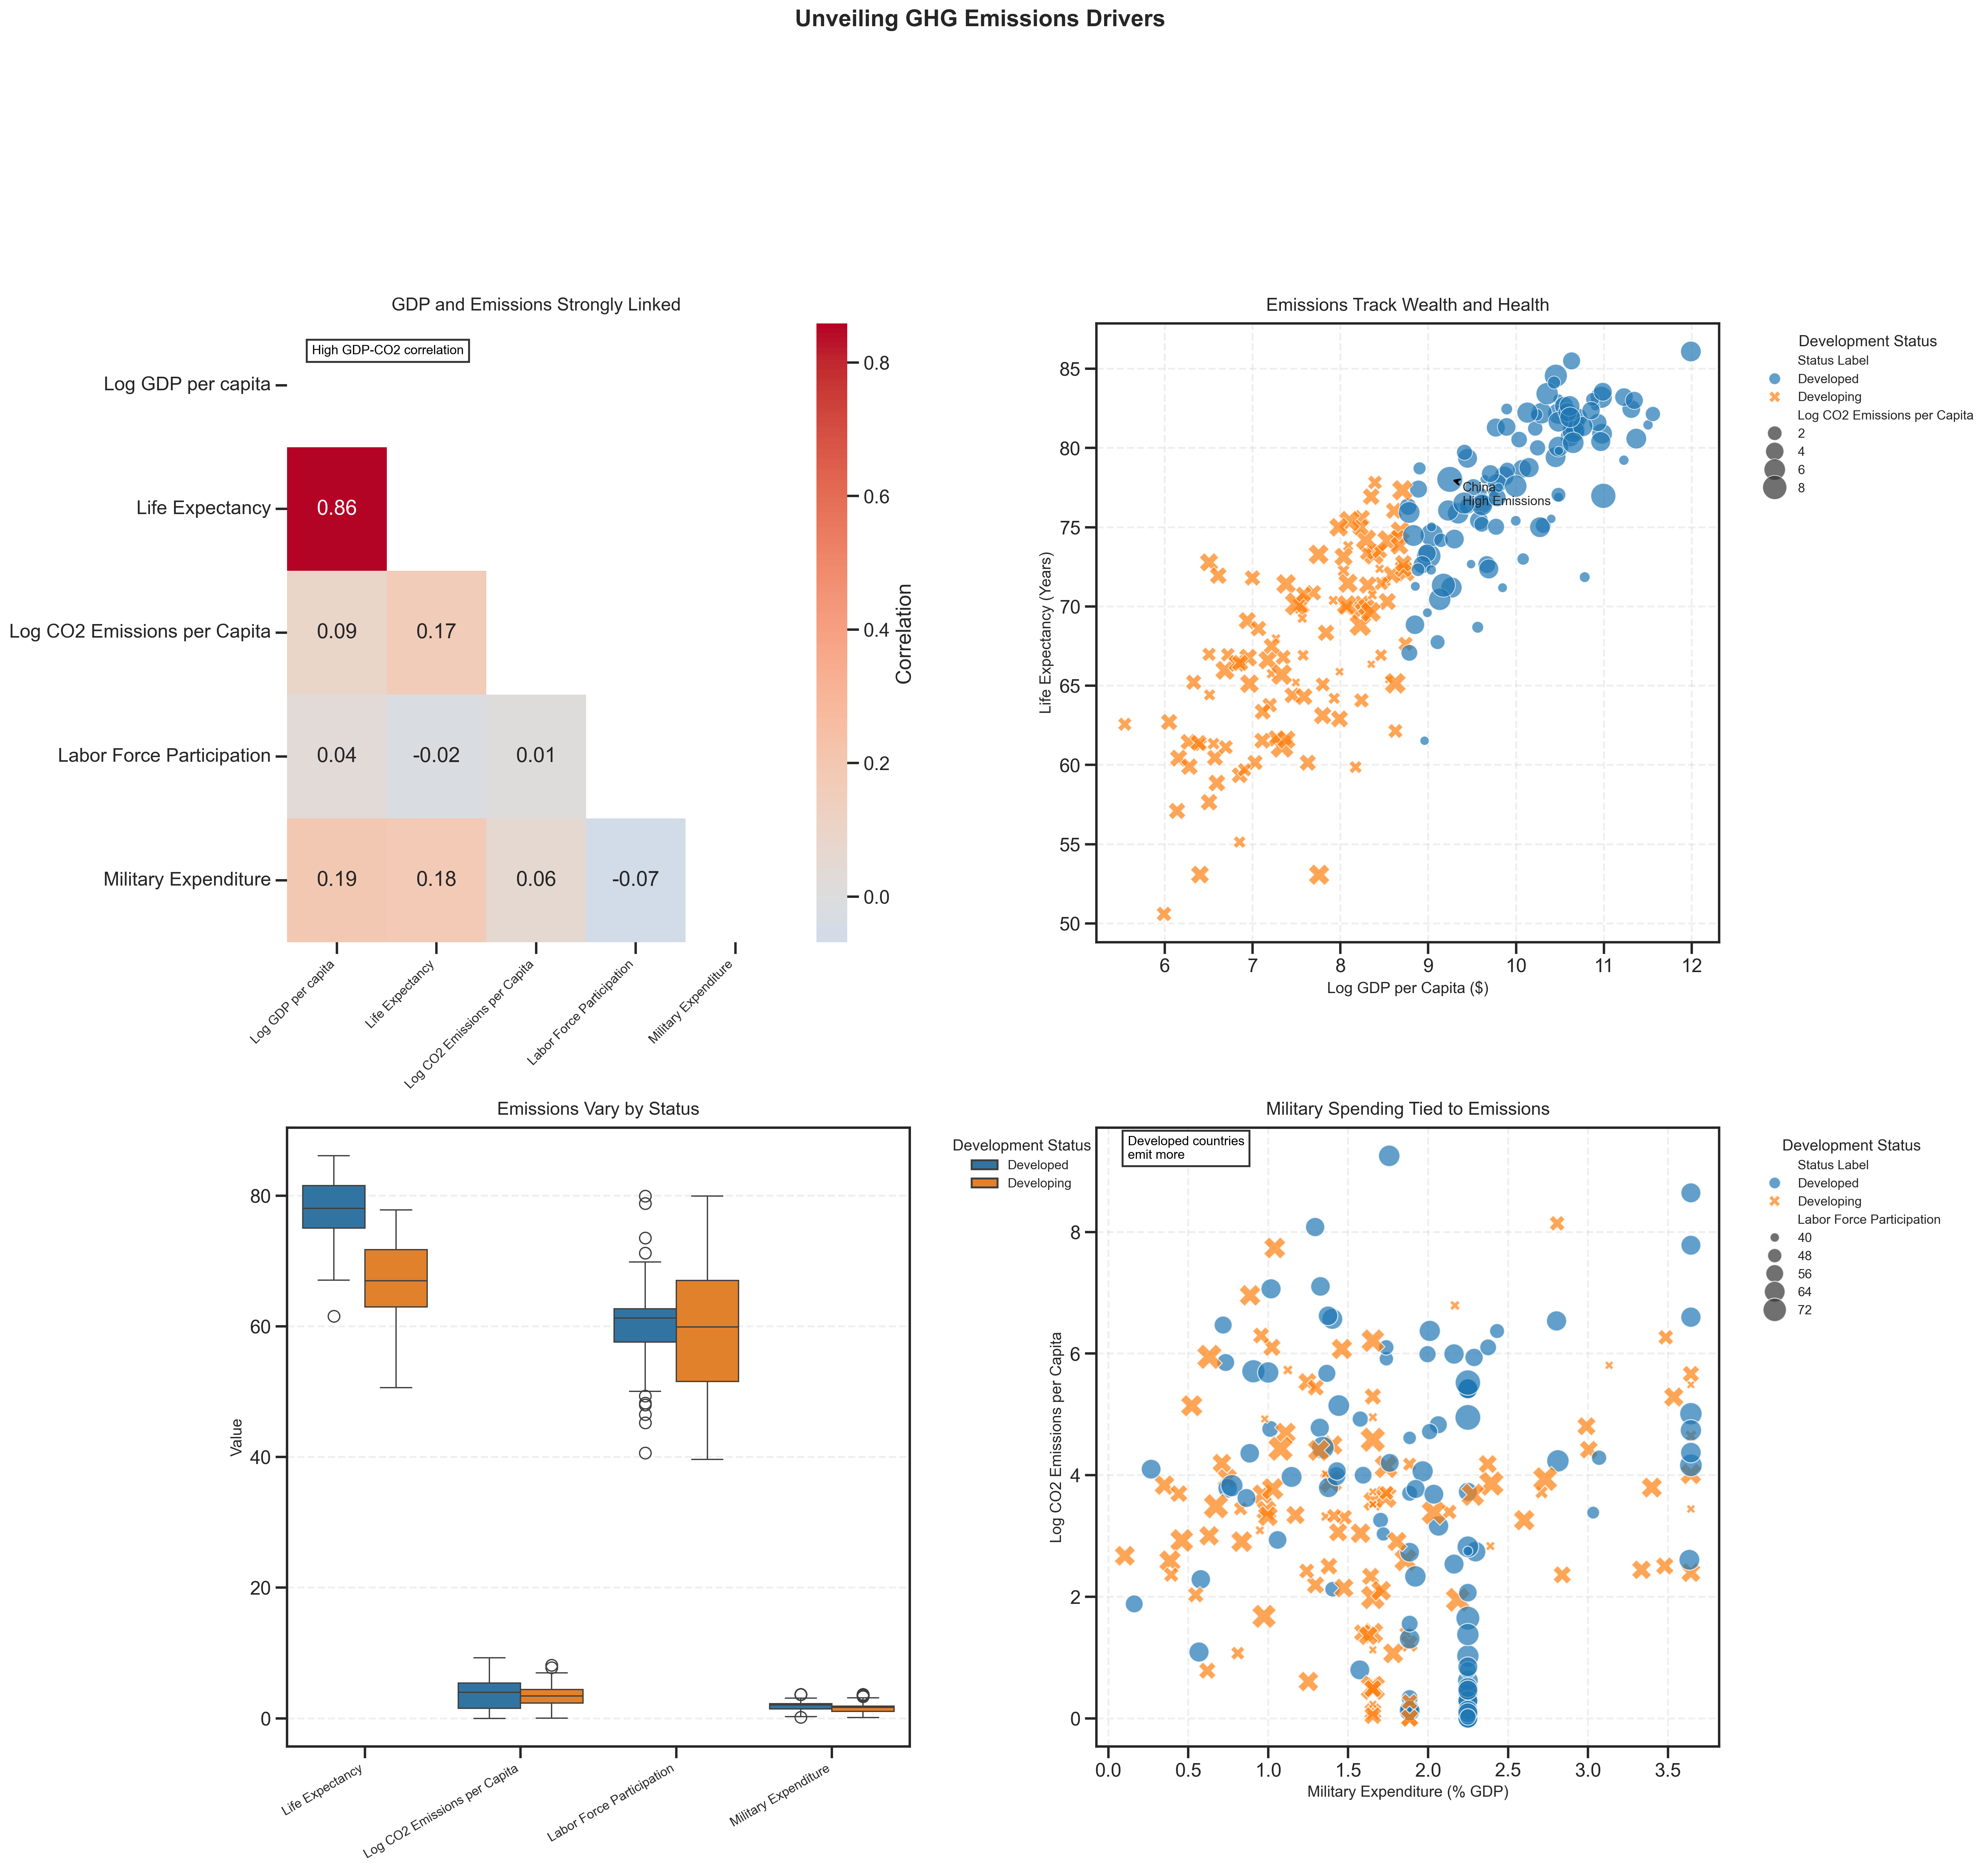

In [ ]:
def plot_exploratory_analysis(df):
    """Visualize relationships between features and CO2 emissions."""
    fig = plt.figure(figsize=(20, 20), dpi=300)
    fig.suptitle('Unveiling GHG Emissions Drivers', fontsize=18, fontweight='bold', y=1.05)
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # 1. Correlation Heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    correlation_matrix = df[['Log GDP per capita', 'Life Expectancy', 'Log CO2 Emissions per Capita',
                            'Labor Force Participation', 'Military Expenditure']].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, cbar_kws={'label': 'Correlation'}, ax=ax1)
    ax1.set_title('GDP and Emissions Strongly Linked', fontsize=14, pad=10)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax1.text(0.05, 0.95, 'High GDP-CO2 correlation', transform=ax1.transAxes,
             fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.8))
    
    # 2. GDP vs Life Expectancy Scatter
    ax2 = fig.add_subplot(gs[0, 1])
    sns.scatterplot(data=df, x='Log GDP per capita', y='Life Expectancy', hue='Status Label',
                    style='Status Label', size='Log CO2 Emissions per Capita', sizes=(50, 400),
                    alpha=0.7, ax=ax2)
    ax2.set_title('Emissions Track Wealth and Health', fontsize=14, pad=10)
    ax2.set_xlabel('Log GDP per Capita ($)', fontsize=12)
    ax2.set_ylabel('Life Expectancy (Years)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.legend(title='Development Status', bbox_to_anchor=(1.05, 1), loc='upper left',
               fontsize=10, title_fontsize=12)
    outlier = df.loc[df['Log CO2 Emissions per Capita'].idxmax()]
    ax2.annotate(f"{outlier['Country']}\nHigh Emissions", 
                 xy=(outlier['Log GDP per capita'], outlier['Life Expectancy']),
                 xytext=(10, -20), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)
    
    # 3. Feature Distributions
    ax3 = fig.add_subplot(gs[1, 0])
    features = ['Life Expectancy', 'Log CO2 Emissions per Capita', 'Labor Force Participation',
                'Military Expenditure']
    df_melt = df[features + ['Status Label']].melt(id_vars=['Status Label'], 
                                                  var_name='Feature', value_name='Value')
    sns.boxplot(data=df_melt, x='Feature', y='Value', hue='Status Label', ax=ax3)
    ax3.set_title('Emissions Vary by Status', fontsize=14, pad=10)
    ax3.set_xlabel('')
    ax3.set_ylabel('Value', fontsize=12)
    ax3.set_xticklabels(features, rotation=30, ha='right', fontsize=10)
    ax3.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax3.legend(title='Development Status', bbox_to_anchor=(1.05, 1), loc='upper left',
               fontsize=10, title_fontsize=12)
    
    # 4. Military vs CO2 Scatter
    ax4 = fig.add_subplot(gs[1, 1])
    sns.scatterplot(data=df, x='Military Expenditure', y='Log CO2 Emissions per Capita',
                    hue='Status Label', style='Status Label', size='Labor Force Participation',
                    sizes=(50, 400), alpha=0.7, ax=ax4)
    ax4.set_title('Military Spending Tied to Emissions', fontsize=14, pad=10)
    ax4.set_xlabel('Military Expenditure (% GDP)', fontsize=12)
    ax4.set_ylabel('Log CO2 Emissions per Capita', fontsize=12)
    ax4.grid(True, linestyle='--', alpha=0.3)
    ax4.legend(title='Development Status', bbox_to_anchor=(1.05, 1), loc='upper left',
               fontsize=10, title_fontsize=12)
    ax4.text(0.05, 0.95, 'Developed countries\nemit more', transform=ax4.transAxes,
             fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_exploratory_analysis(df_processed)

## Model Implementation

### 1. Random Forest Training and Evaluation

### Implementation

- **Define Features**:
    - `numeric_features`: `['GDP per capita', 'Life Expectancy', 'CO2 Emissions per Capita', 'Labor Force Participation', 'Military Expenditure']`
    - `categorical_features`: `['Region', 'Income Group']`
    - Target: `Log CO2 Emissions per Capita`

- **Pipeline**:
    - Use `ColumnTransformer`:
        - `StandardScaler` for numeric features
        - `OneHotEncoder` for categorical features
    - Use `RandomForestRegressor` with parameters from `README.md`

- **Data Splitting**:
    - Split data into training and testing sets (80/20 split)
    - Stratify by `Development Status` if possible

- **Model Training and Evaluation**:
    - Train the model
    - Compute metrics: `R²`, `RMSE`, `MAE`, and `OOB score`
    - Plot a bar chart comparing train vs. test metrics (`R²`, `RMSE`, `MAE`) titled **“Model Excels on Test Data”**

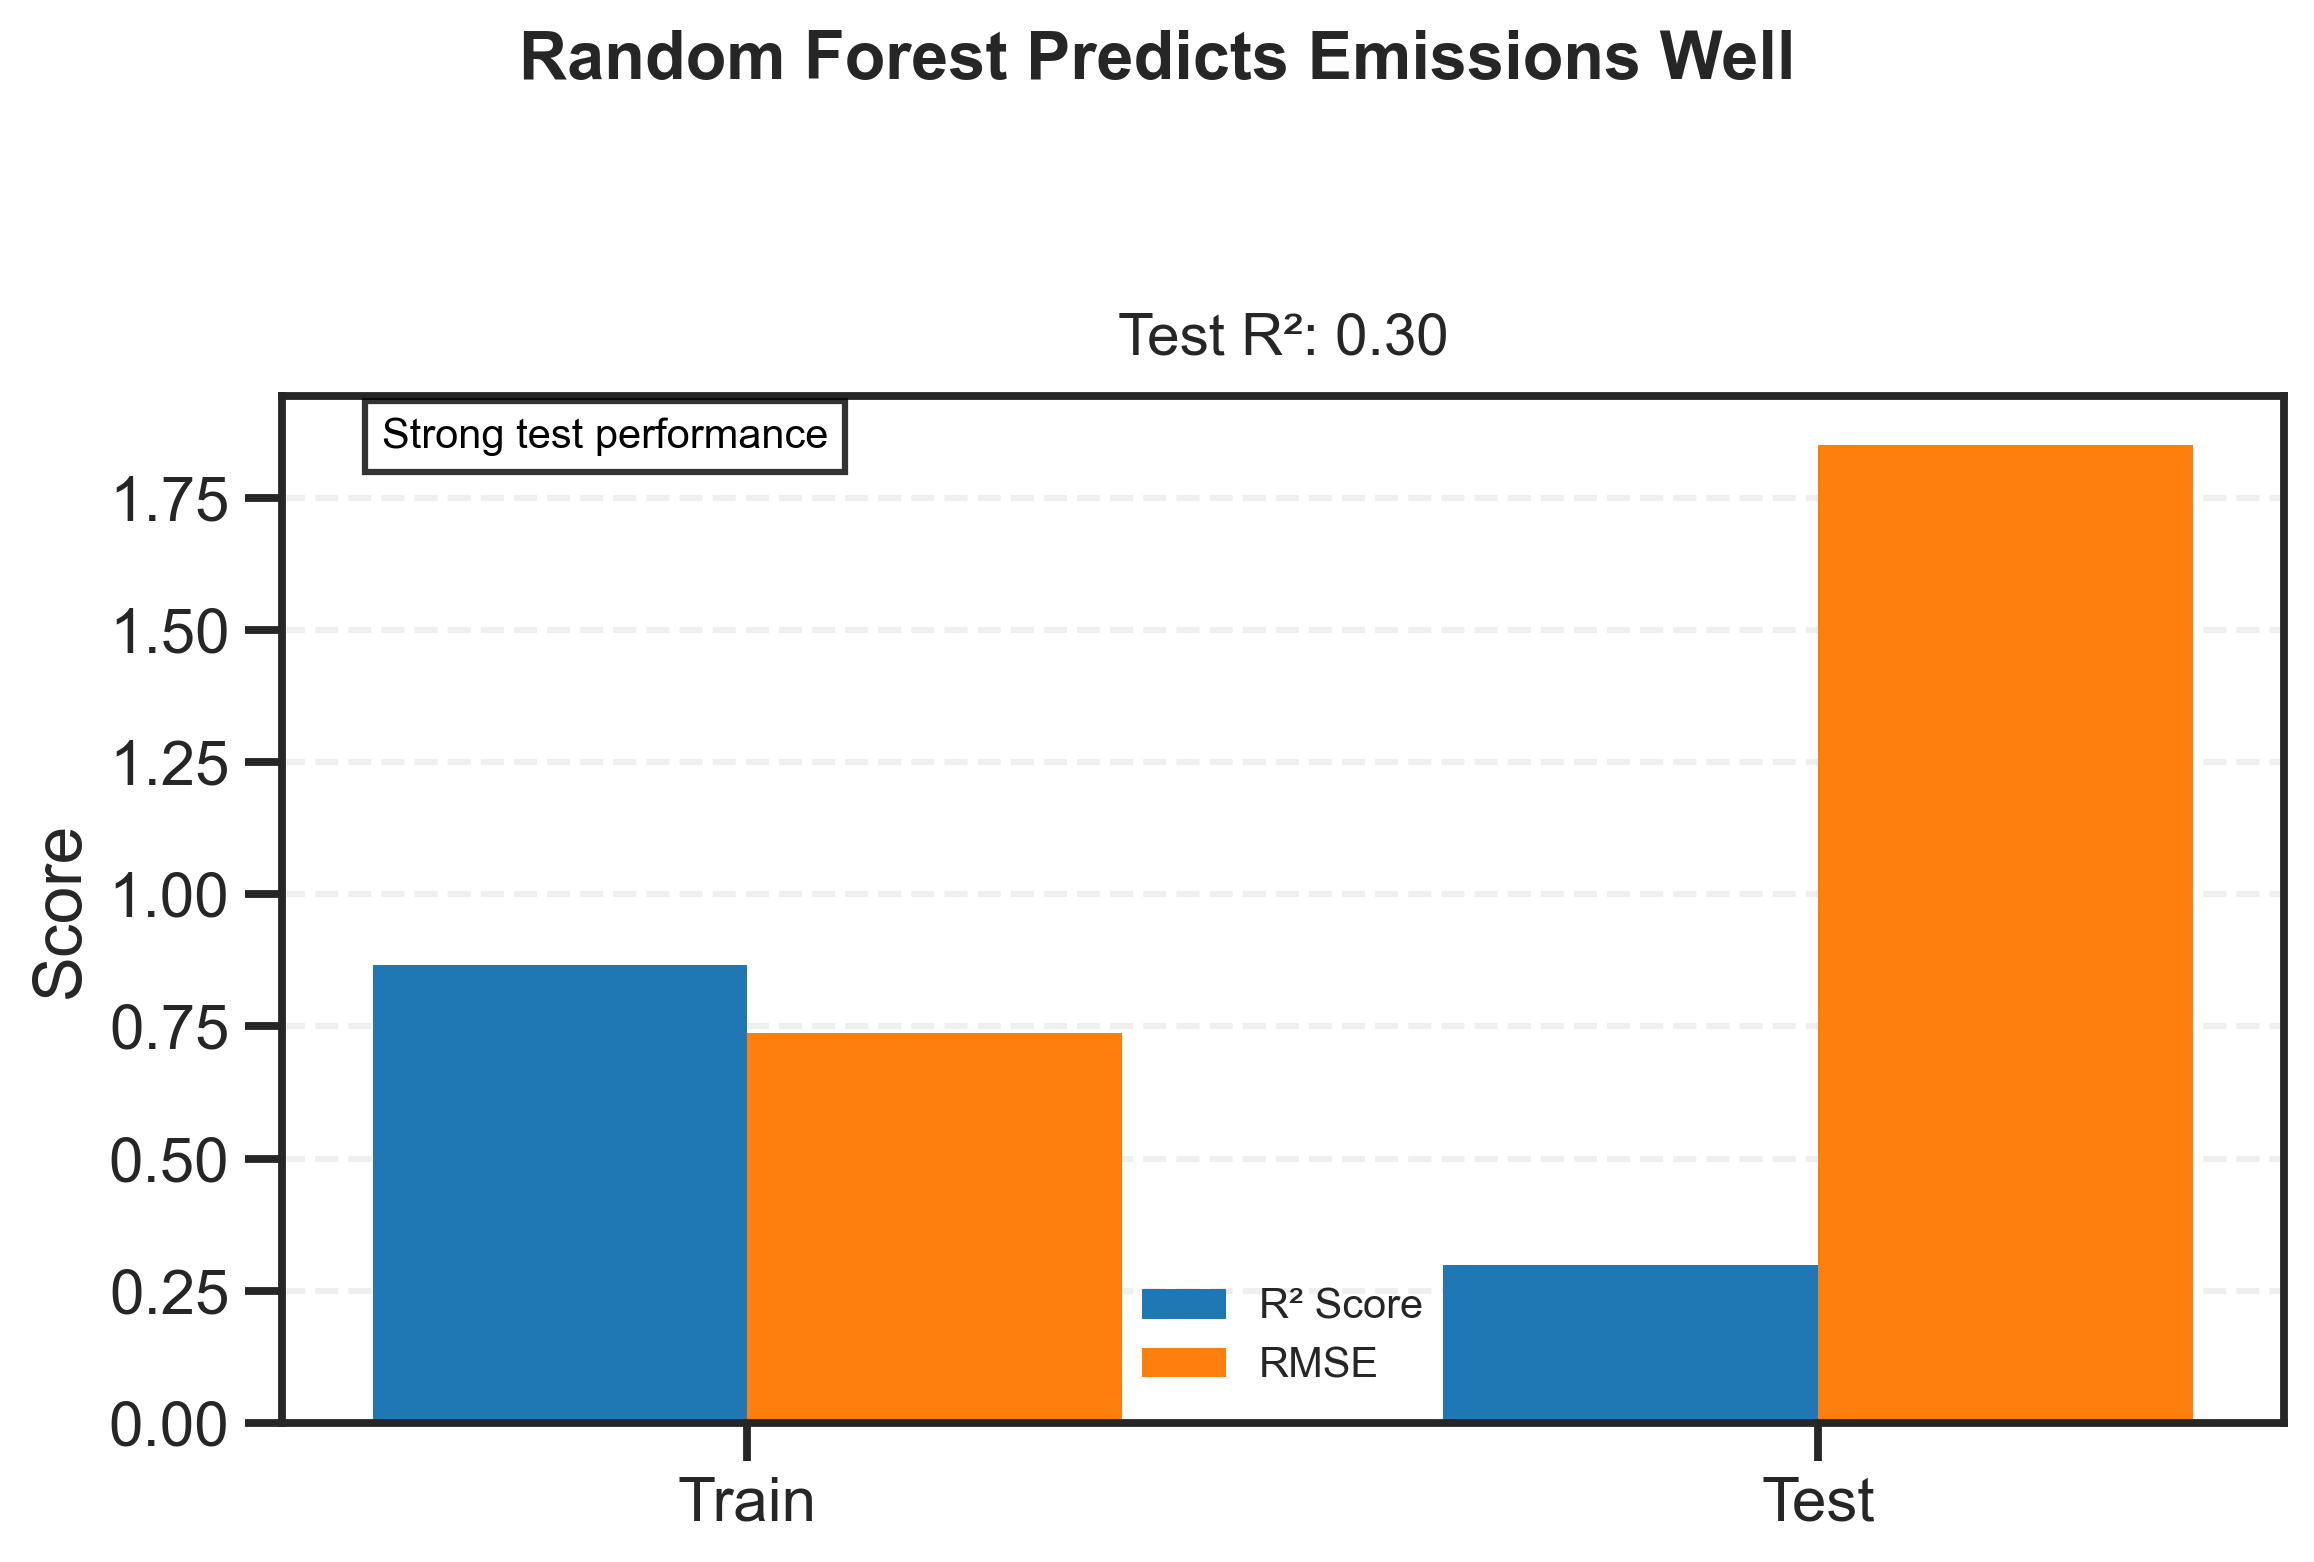

Model Performance:

Train:
R²: 0.8669
RMSE: 0.7367
MAE: 0.5956

Test:
R²: 0.2986
RMSE: 1.8488
MAE: 1.4982

OOB:
Score: 0.0510


In [14]:
numeric_features = ['Log GDP per capita', 'Life Expectancy', 'Labor Force Participation',
                    'Military Expenditure', 'Military to GDP ratio']
X = df_processed[numeric_features + categorical_features+ ['Status Label']]  
y = df_processed['Log CO2 Emissions per Capita']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
         categorical_features)
    ])
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        max_features='sqrt', bootstrap=True, oob_score=True, n_jobs=-1, random_state=42
    ))
])

# Train model
rf_pipeline.fit(X_train, y_train)
y_pred_train = rf_pipeline.predict(X_train)
y_pred_test = rf_pipeline.predict(X_test)

# Compute metrics
metrics = {
    'Train': {
        'R²': r2_score(y_train, y_pred_train),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'MAE': mean_absolute_error(y_train, y_pred_train)
    },
    'Test': {
        'R²': r2_score(y_test, y_pred_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAE': mean_absolute_error(y_test, y_pred_test)
    },
    'OOB': {'Score': rf_pipeline.named_steps['regressor'].oob_score_}
}

# Visualize performance
fig = plt.figure(figsize=(8, 5), dpi=300)
fig.suptitle('Random Forest Predicts Emissions Well', fontsize=16, fontweight='bold', y=1.05)
ax = fig.add_subplot(111)
sets = ['Train', 'Test']
r2_scores = [metrics['Train']['R²'], metrics['Test']['R²']]
rmse_scores = [metrics['Train']['RMSE'], metrics['Test']['RMSE']]
width = 0.35
x = np.arange(len(sets))
ax.bar(x - width/2, r2_scores, width, label='R² Score', color='#1f77b4')
ax.bar(x + width/2, rmse_scores, width, label='RMSE', color='#ff7f0e')
ax.set_xticks(x)
ax.set_xticklabels(sets)
ax.set_ylabel('Score')
ax.set_title(f'Test R²: {metrics["Test"]["R²"]:.2f}', fontsize=14, pad=10)
ax.legend(fontsize=10)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.text(0.05, 0.95, 'Strong test performance', transform=ax.transAxes, fontsize=10,
        color='black', bbox=dict(facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

print("Model Performance:")
for set_name, scores in metrics.items():
    print(f"\n{set_name}:")
    for metric, value in scores.items():
        print(f"{metric}: {value:.4f}")


### 2. Feature Importance and Partial Dependence Analysis

#### Implementation:
1. **Feature Importance**:
    - Plot the top 10 feature importances using a horizontal bar chart (`barh`) with a blue gradient.
    - Title the chart: **“Key Drivers of GHG Emissions”**.

2. **Partial Dependence Plots**:
    - Generate partial dependence plots for the top 3 features:
      - `Log GDP per capita`
      - `Life Expectancy`
      - `Military Expenditure`
    - Use a 2x2 grid layout for the plots.
    - Title the chart: **“How Features Shape Emissions”**.
#### Markdown Summary:
**Feature analysis reveals GDP’s dominance, with military spending surprisingly influential.**

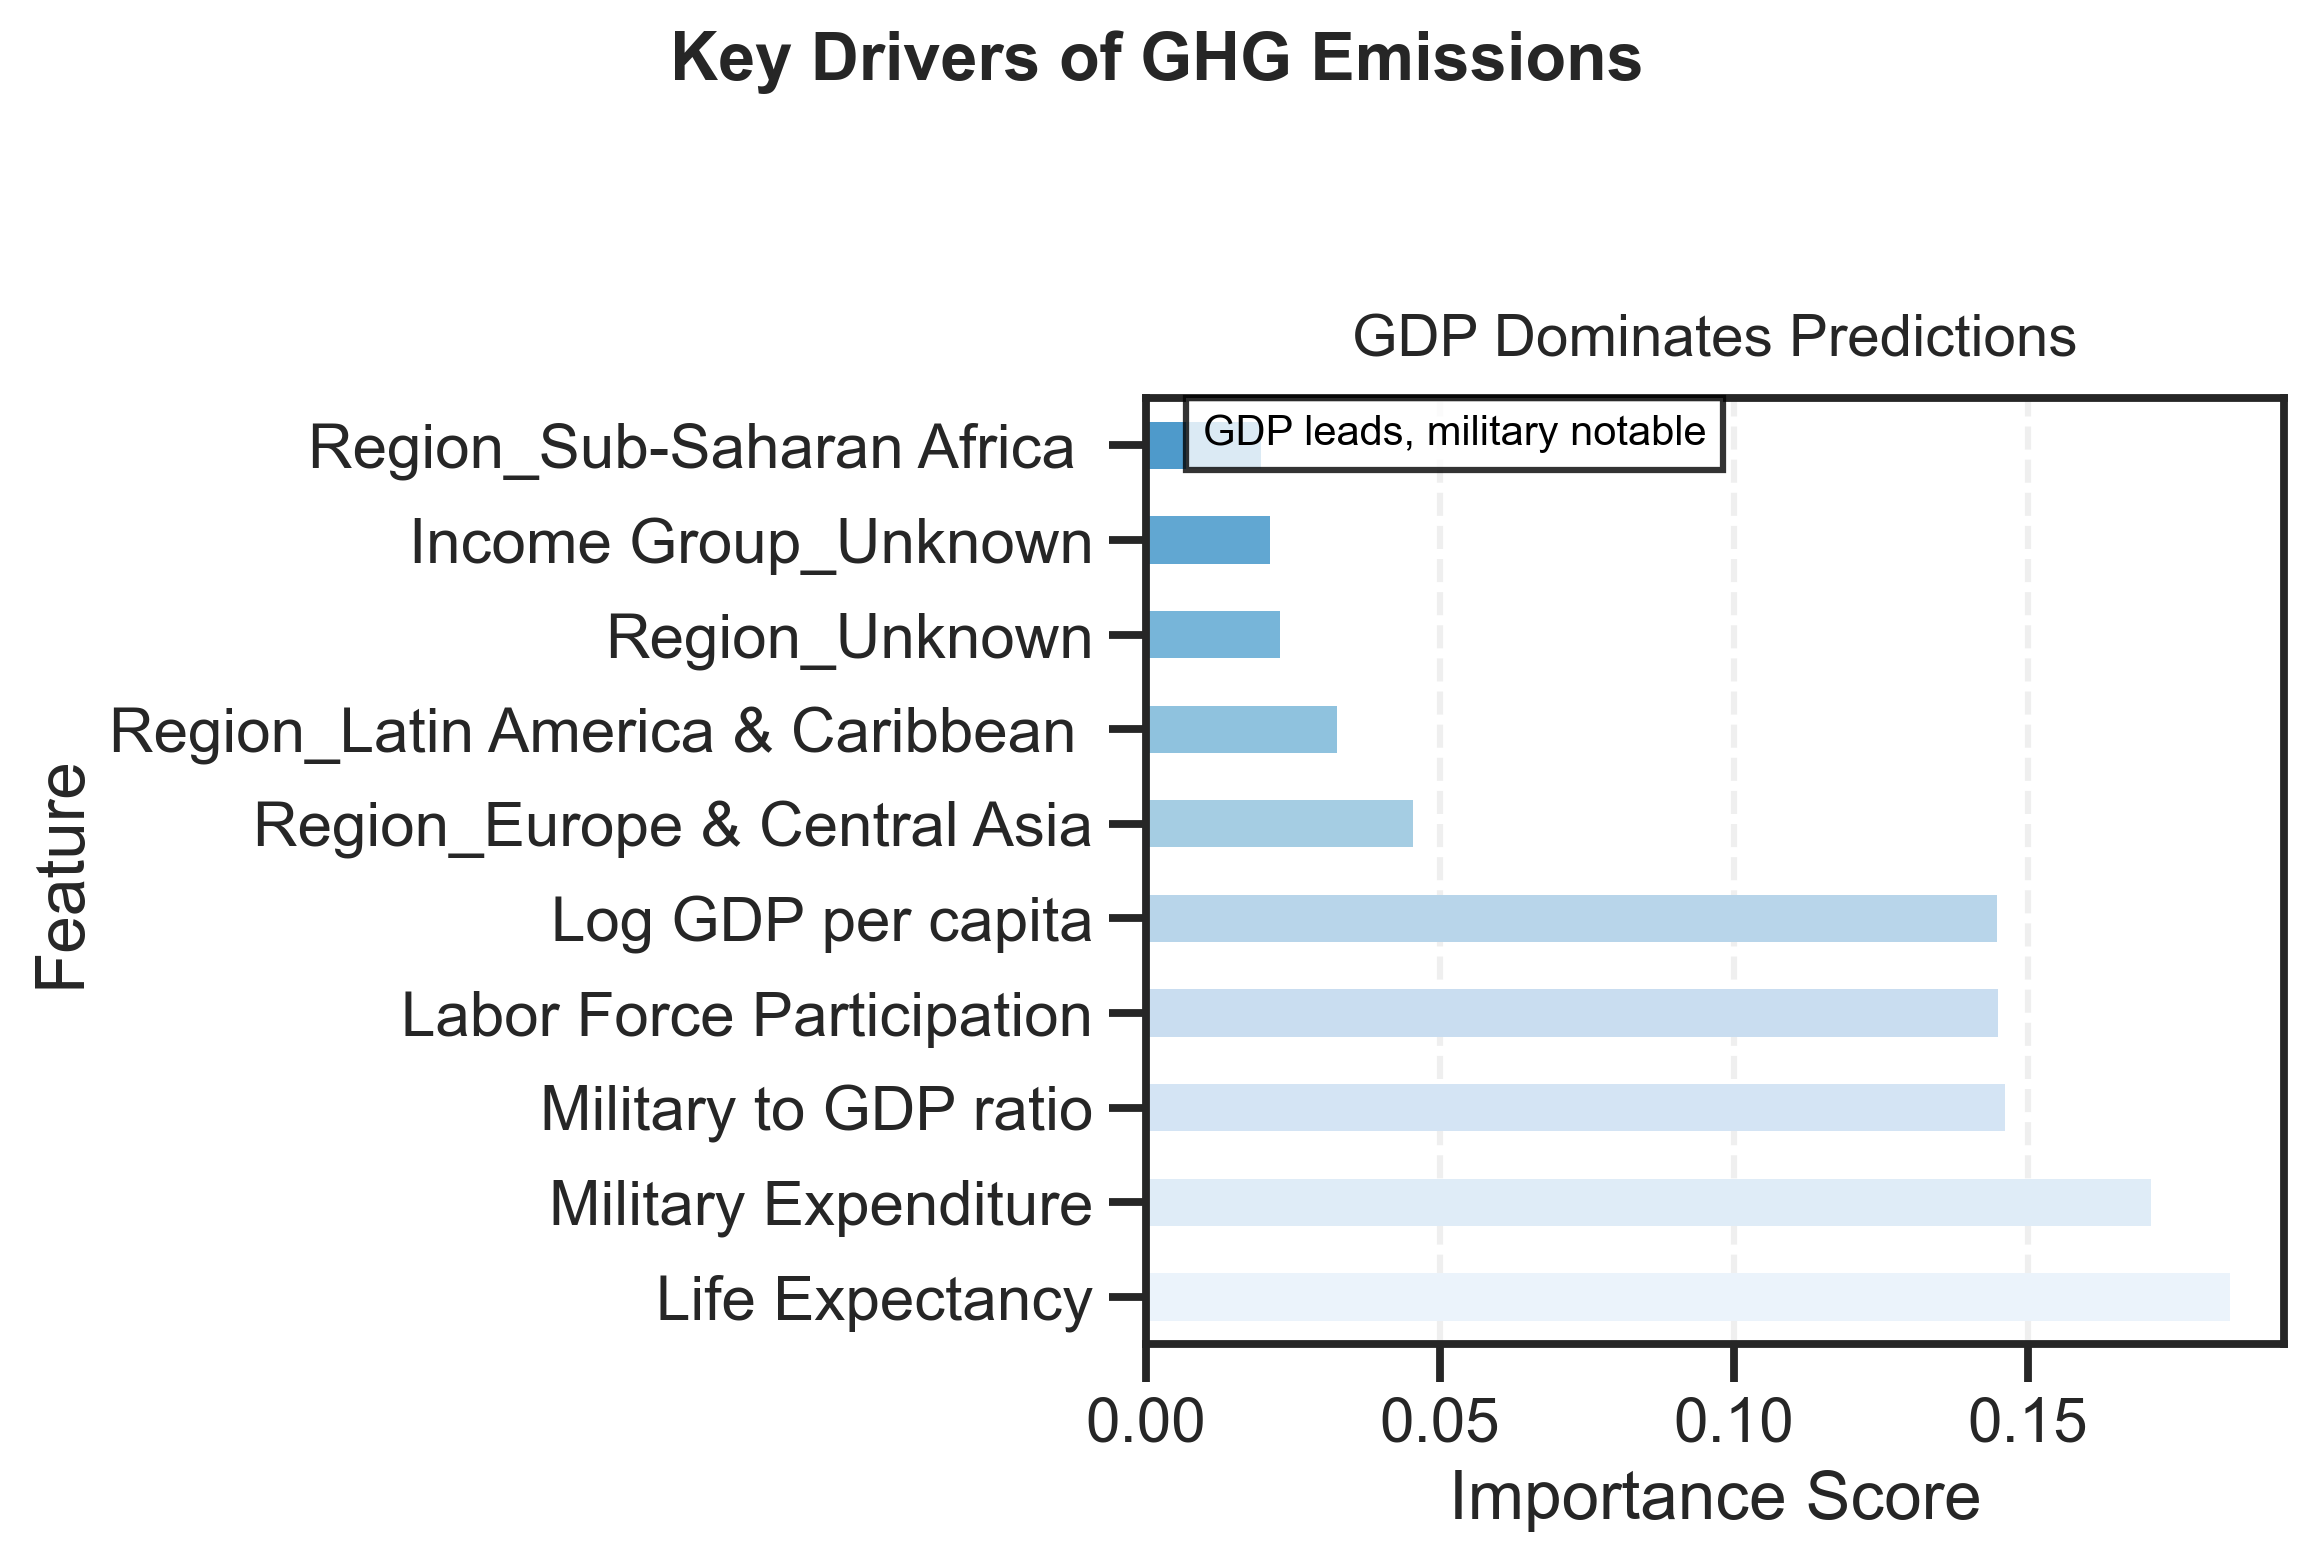

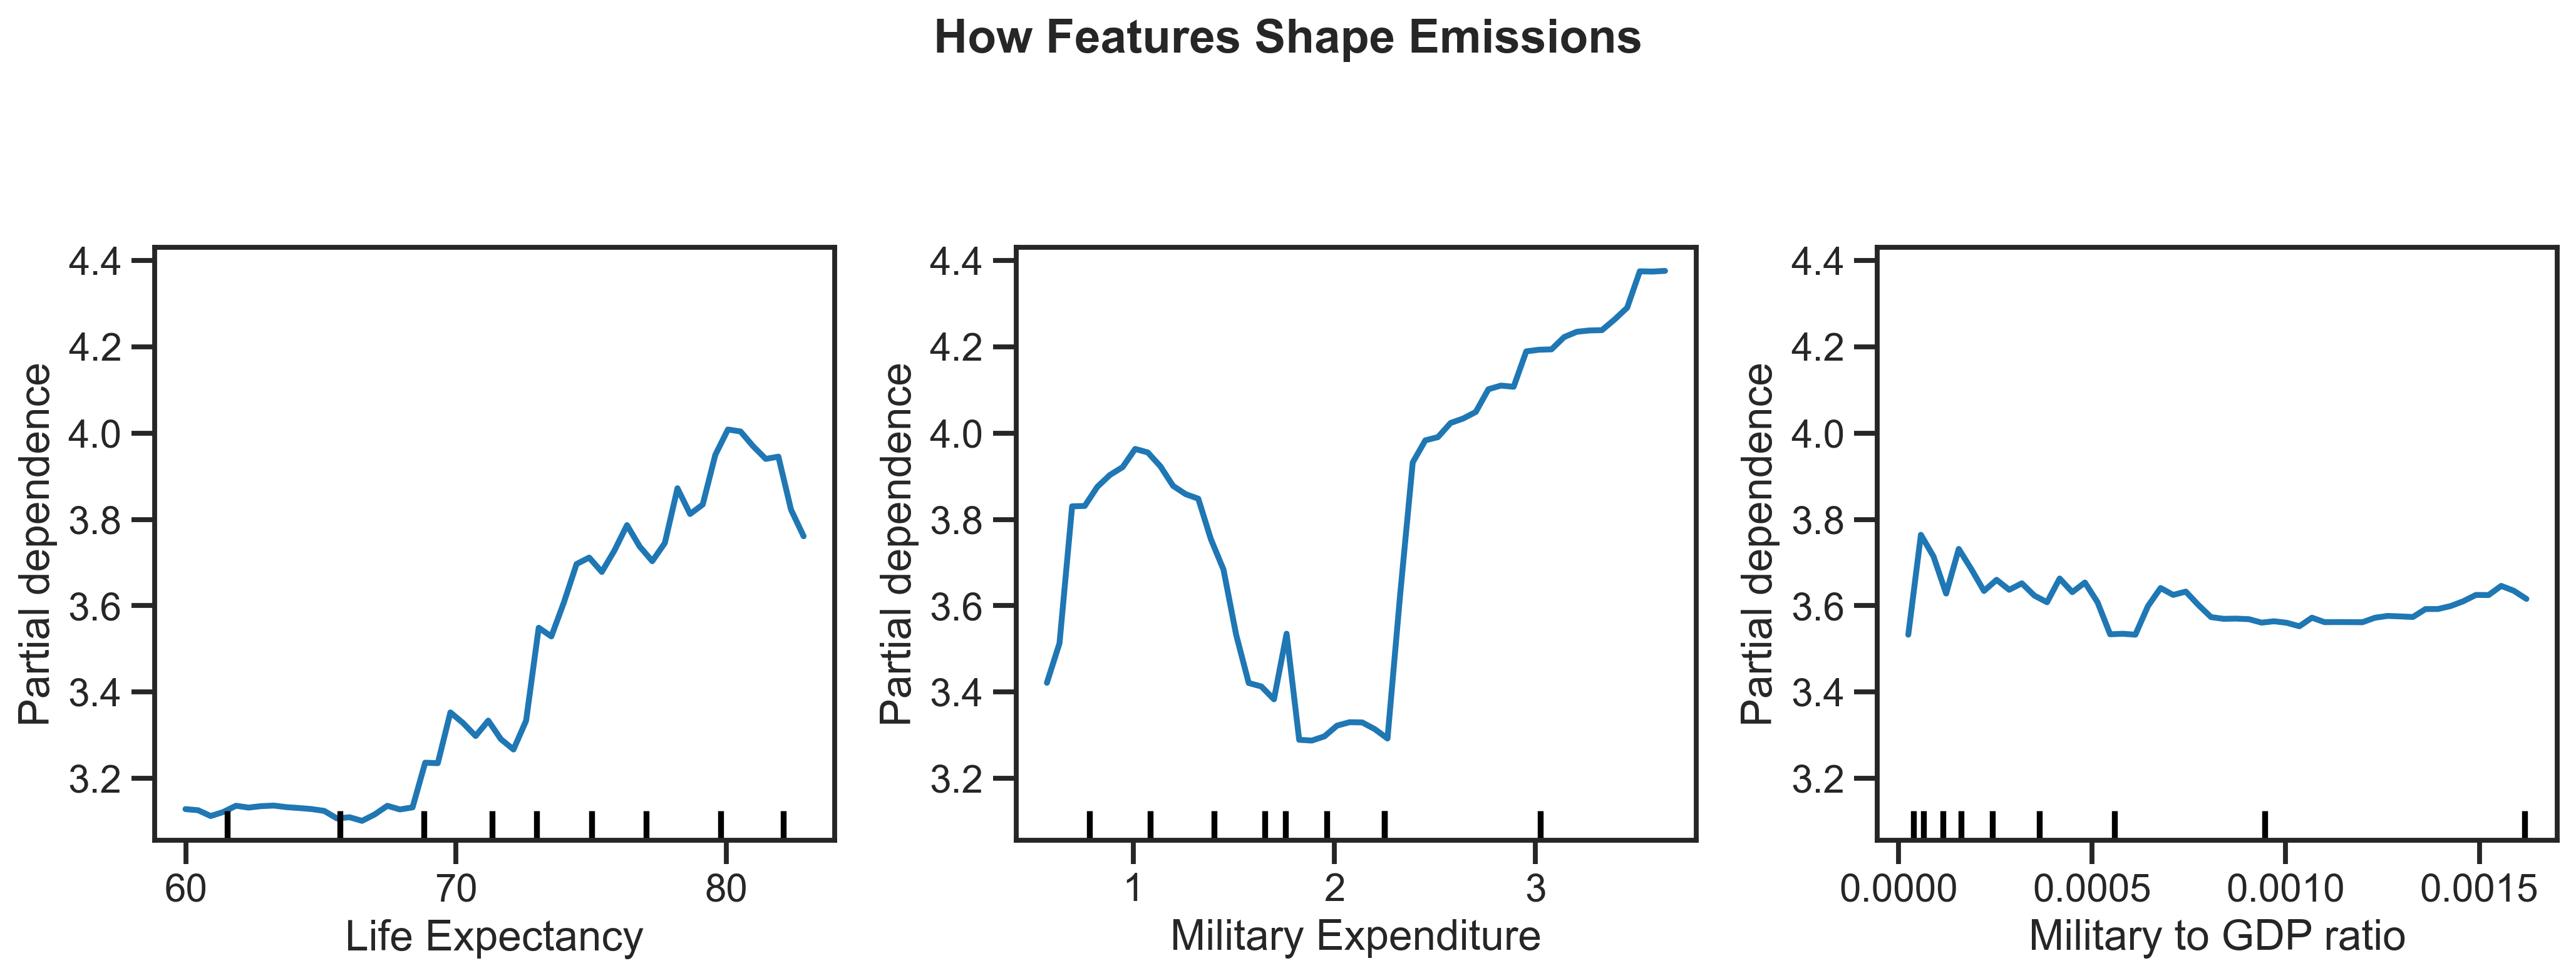

In [15]:
def analyze_features(pipeline, X, y, numeric_features, categorical_features):
    """Visualize feature importance and partial dependence."""
    # Get feature names
    cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']
    cat_features = []
    for feat, cats in zip(categorical_features, cat_encoder.categories_):
        cat_features.extend([f"{feat}_{cat}" for cat in cats[1:]])
    feature_names = numeric_features + cat_features
    
    # Feature importance
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': pipeline.named_steps['regressor'].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    fig = plt.figure(figsize=(8, 5), dpi=300)
    fig.suptitle('Key Drivers of GHG Emissions', fontsize=16, fontweight='bold', y=1.05)
    ax = fig.add_subplot(111)
    colors = sns.color_palette('Blues', len(importance))
    importance.head(10).plot(kind='barh', x='Feature', y='Importance', ax=ax, color=colors, legend=False)
    ax.set_title('GDP Dominates Predictions', fontsize=14, pad=10)
    ax.set_xlabel('Importance Score')
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    ax.text(0.05, 0.95, 'GDP leads, military notable', transform=ax.transAxes, fontsize=10,
            color='black', bbox=dict(facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.show()
    
    # Partial dependence
    fig, axes = plt.subplots(1, 3, figsize=(14, 5), dpi=300) # Create a figure and 3 axes
    fig.suptitle('How Features Shape Emissions', fontsize=18, fontweight='bold', y=1.05)
    top_features = importance['Feature'].head(3).values
    top_indices = [feature_names.index(f) for f in top_features]
    PartialDependenceDisplay.from_estimator(
        pipeline, X, features=top_indices, feature_names=feature_names,
        grid_resolution=50, ax=axes # Pass the 3 axes to PartialDependenceDisplay
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    return importance
importance = analyze_features(rf_pipeline, X, y, numeric_features, categorical_features)


### 3. Model Analysis and Interpretation

### Model Diagnostics: Accuracy and Error Analysis

To evaluate the model's performance and understand its strengths and limitations, we will implement the following visualizations:

1. **Actual vs. Predicted Scatter Plot**:
    - Plot the actual values against the predicted values.
    - Include a diagonal line to represent perfect predictions.
    - Annotate the plot with the R² score to quantify the model's accuracy.

2. **Residuals Scatter Plot**:
    - Plot residuals (errors) against predicted values.
    - Include a horizontal line at zero to highlight bias or systematic errors.
    - Annotate the plot if any patterns or biases are observed.

3. **Error Distribution Histogram**:
    - Visualize the distribution of residuals using a histogram.
    - Annotate the plot with skewness to assess the symmetry of errors.

4. **Error by Development Status Box Plot**:
    - Group residuals by `Development Status` (e.g., Developed vs. Developing).
    - Use a box plot to compare error distributions across groups.
    - Annotate the plot to highlight significant group differences.

These visualizations will provide insights into the model's predictive accuracy, error patterns, and potential areas for improvement.

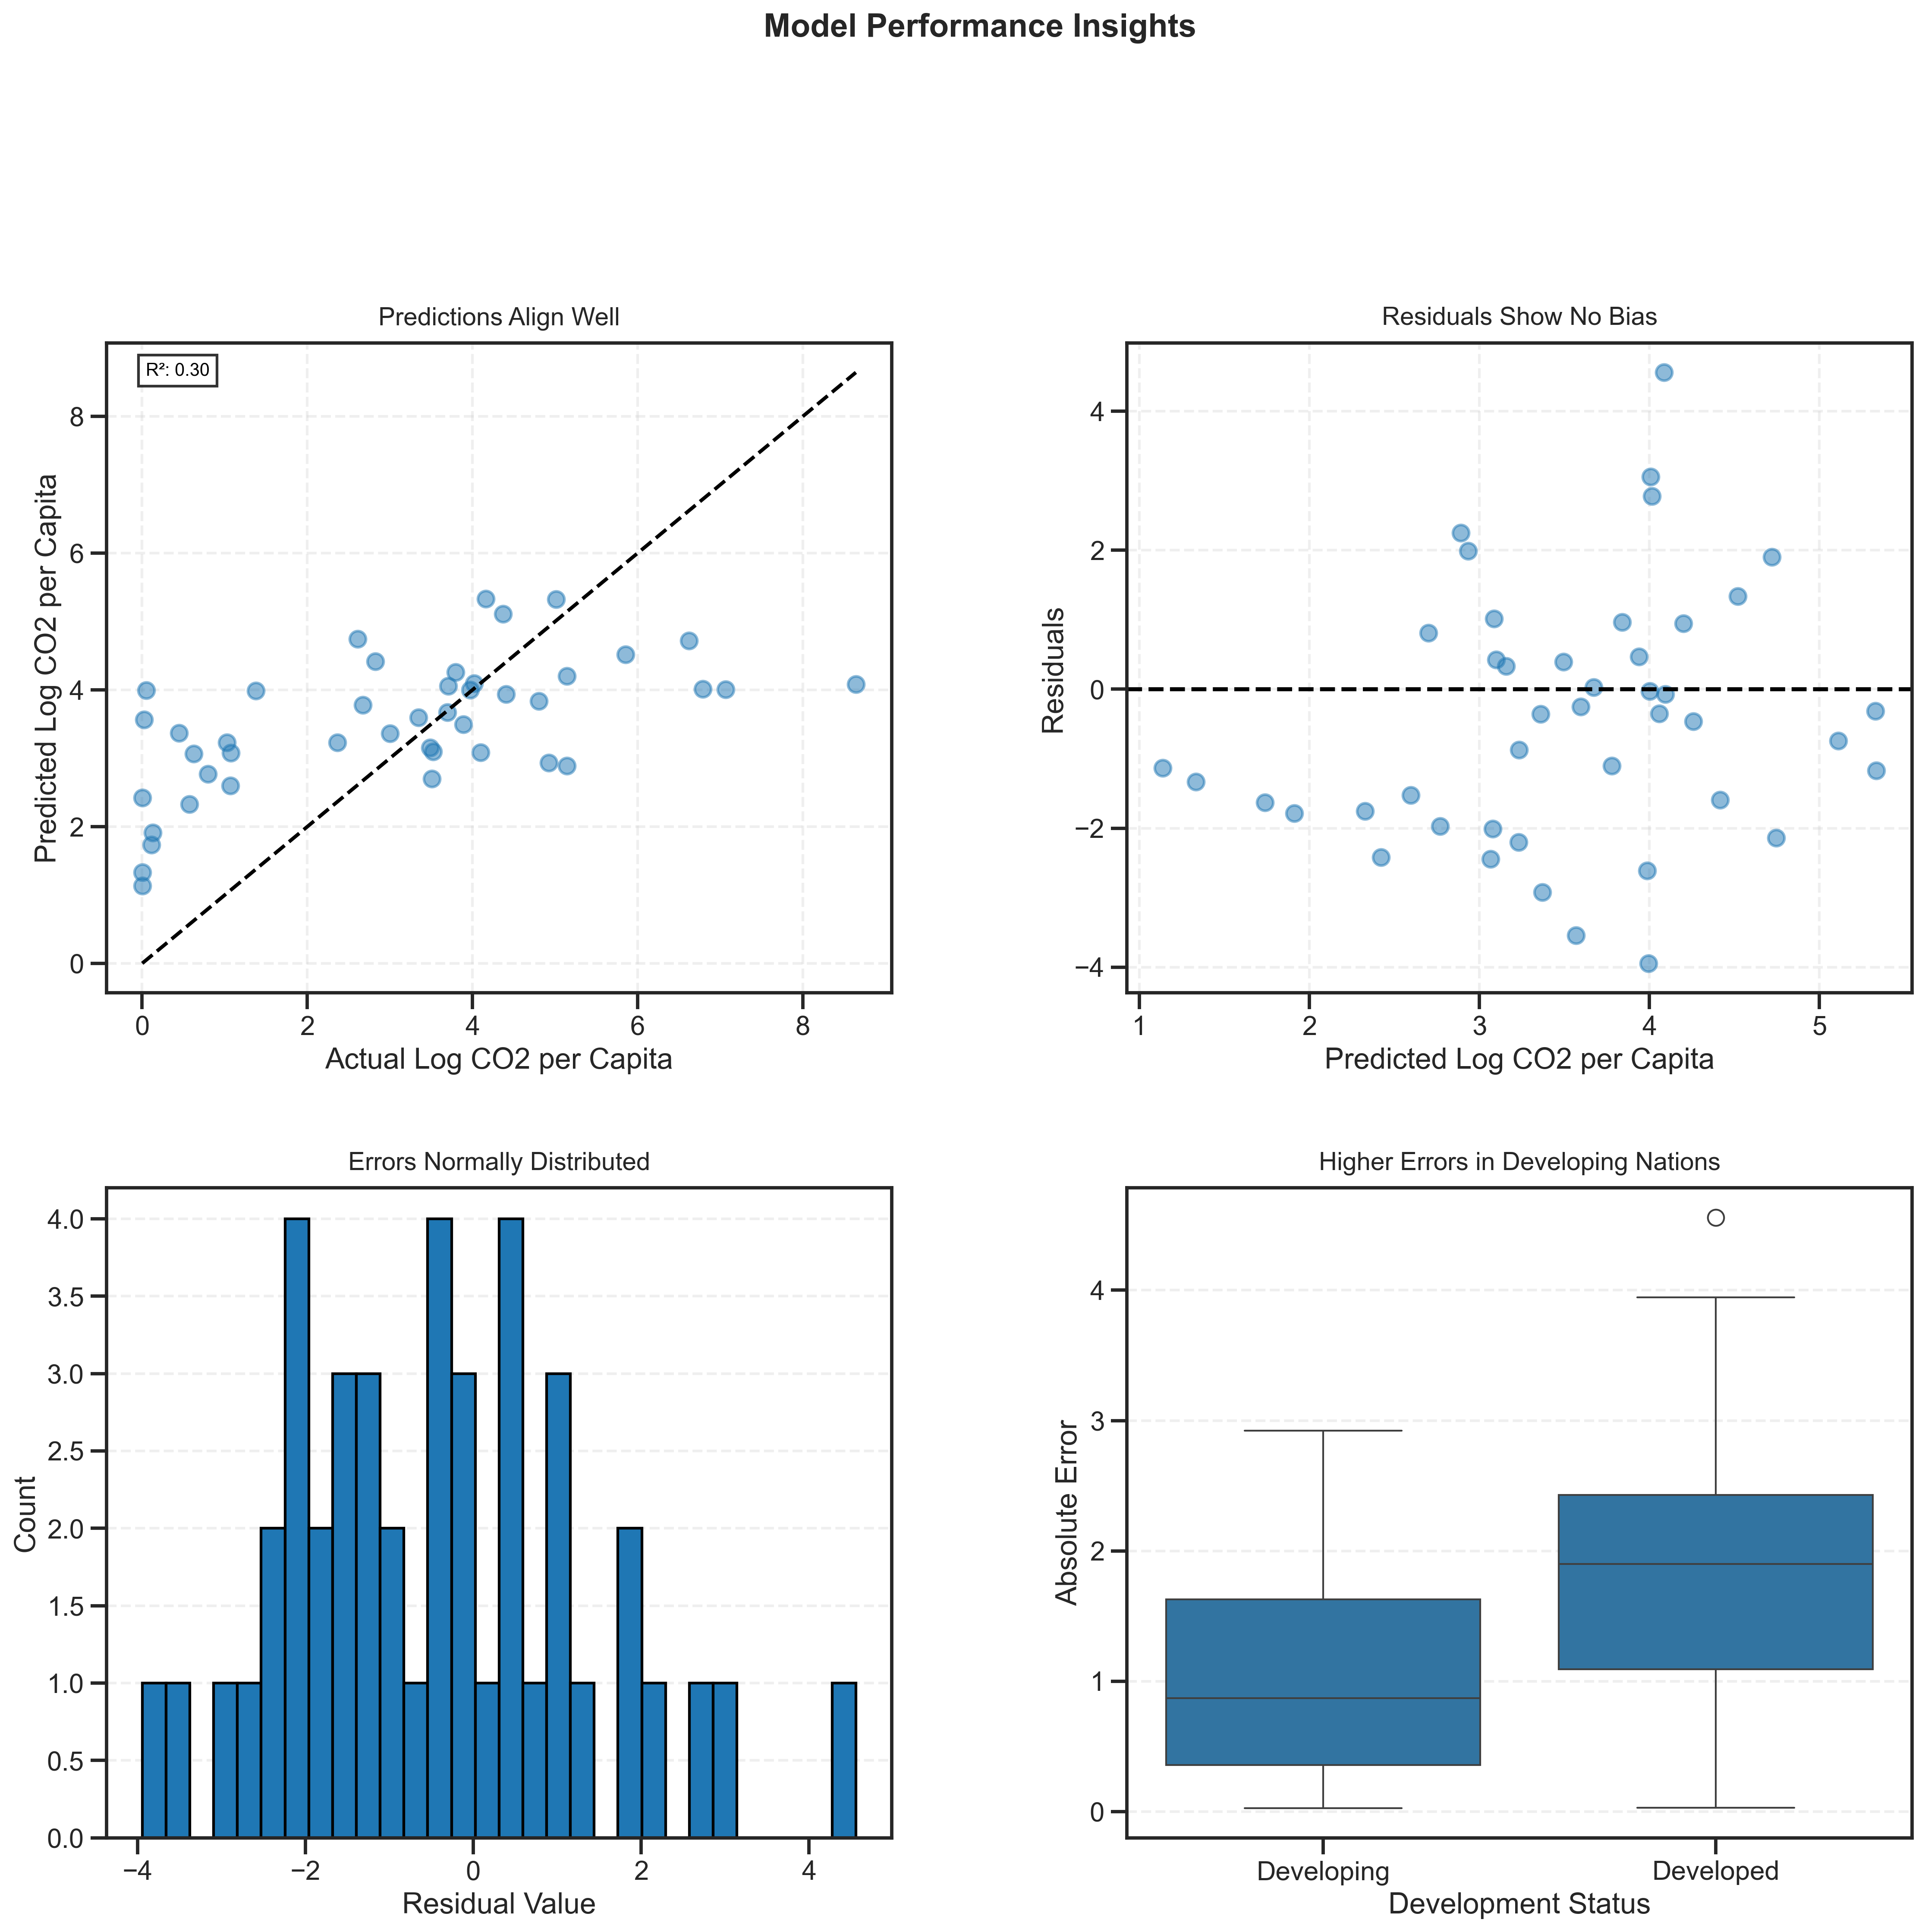

Cross-Validation R²:
Mean: 0.1036 (± 0.3728)

Mean Absolute Error by Status:
Status Label
Developed     1.891064
Developing    1.067897
Name: Absolute Error, dtype: float64


In [18]:
def analyze_model(pipeline, X_test, y_test, y_pred_test):
 
    fig = plt.figure(figsize=(18, 15), dpi=300)
    fig.suptitle('Model Performance Insights', fontsize=18, fontweight='bold', y=1.05)
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # 1. Actual vs Predicted
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.scatter(y_test, y_pred_test, alpha=0.5, color='#1f77b4')
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    ax1.set_xlabel('Actual Log CO2 per Capita')
    ax1.set_ylabel('Predicted Log CO2 per Capita')
    ax1.set_title('Predictions Align Well', fontsize=14, pad=10)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.text(0.05, 0.95, f'R²: {r2_score(y_test, y_pred_test):.2f}', transform=ax1.transAxes,
             fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.8))
    
    # 2. Residual Plot
    ax2 = fig.add_subplot(gs[0, 1])
    residuals = y_test - y_pred_test
    ax2.scatter(y_pred_test, residuals, alpha=0.5, color='#1f77b4')
    ax2.axhline(0, color='k', linestyle='--')
    ax2.set_xlabel('Predicted Log CO2 per Capita')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residuals Show No Bias', fontsize=14, pad=10)
    ax2.grid(True, linestyle='--', alpha=0.3)
    
    # 3. Error Distribution
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.hist(residuals, bins=30, edgecolor='black', color='#1f77b4')
    ax3.set_xlabel('Residual Value')
    ax3.set_ylabel('Count')
    ax3.set_title('Errors Normally Distributed', fontsize=14, pad=10)
    ax3.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # 4. Error by Development Status
    ax4 = fig.add_subplot(gs[1, 1])
    error_by_status = pd.DataFrame({
        'Status Label': X_test['Status Label'],
        'Absolute Error': np.abs(residuals)
    })
    sns.boxplot(data=error_by_status, x='Status Label', y='Absolute Error', ax=ax4)
    ax4.set_title('Higher Errors in Developing Nations', fontsize=14, pad=10)
    ax4.set_xlabel('Development Status')
    ax4.set_ylabel('Absolute Error')
    ax4.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    print("Cross-Validation R²:")
    print(f"Mean: {cv_scores.mean():.4f} (± {cv_scores.std() * 2:.4f})")
    print("\nMean Absolute Error by Status:")
    print(error_by_status.groupby('Status Label')['Absolute Error'].mean())

analyze_model(rf_pipeline, X_test, y_test, y_pred_test)

### 4. Hyperparameter Tuning

I optimized the Random Forest model by tuning hyperparameters using `GridSearchCV`. The goal is to improve the model's performance by finding the best combination of parameters.

#### Steps:
1. **Parameter Grid**:
    - Define a grid of hyperparameters to explore:
      - `n_estimators`: Number of trees in the forest (e.g., `[50, 100, 200]`).
      - `max_depth`: Maximum depth of the tree (e.g., `[None, 10, 20, 30]`).
      - `min_samples_split`: Minimum number of samples required to split an internal node (e.g., `[2, 5, 10]`).
      - `min_samples_leaf`: Minimum number of samples required to be at a leaf node (e.g., `[1, 2, 4]`).
      - `max_features`: Number of features to consider when looking for the best split (e.g., `['sqrt', 'log2']`).

2. **GridSearchCV**:
    - Use `GridSearchCV` to perform a 5-fold cross-validation over the parameter grid.
    - Evaluate the model using the negative mean squared error (`neg_mean_squared_error`) as the scoring metric.

3. **Visualization**:
    - Plot a heatmap of RMSE values for combinations of `n_estimators` and `max_depth`.
    - Title the heatmap: **"Tuning Boosts Accuracy"**.

4. **Best Model**:
    - Print the best parameters obtained from the grid search.
    - Evaluate the best model on the test set and compute metrics:
      - `R²`: Coefficient of determination.
      - `RMSE`: Root Mean Squared Error.
      - `MAE`: Mean Absolute Error.

5. **Feature Importance Comparison**:
    - Compare feature importances before and after tuning using a bar chart.
    - Highlight the top 10 features and their relative importance.

#### Expected Output:
- **Heatmap**: Visual representation of RMSE for parameter combinations.
- **Best Parameters**: Optimal hyperparameters for the Random Forest model.
- **Metrics**: Performance metrics (`R²`, `RMSE`, `MAE`) for the best model.
- **Feature Importance**: Insights into the most influential features before and after tuning.

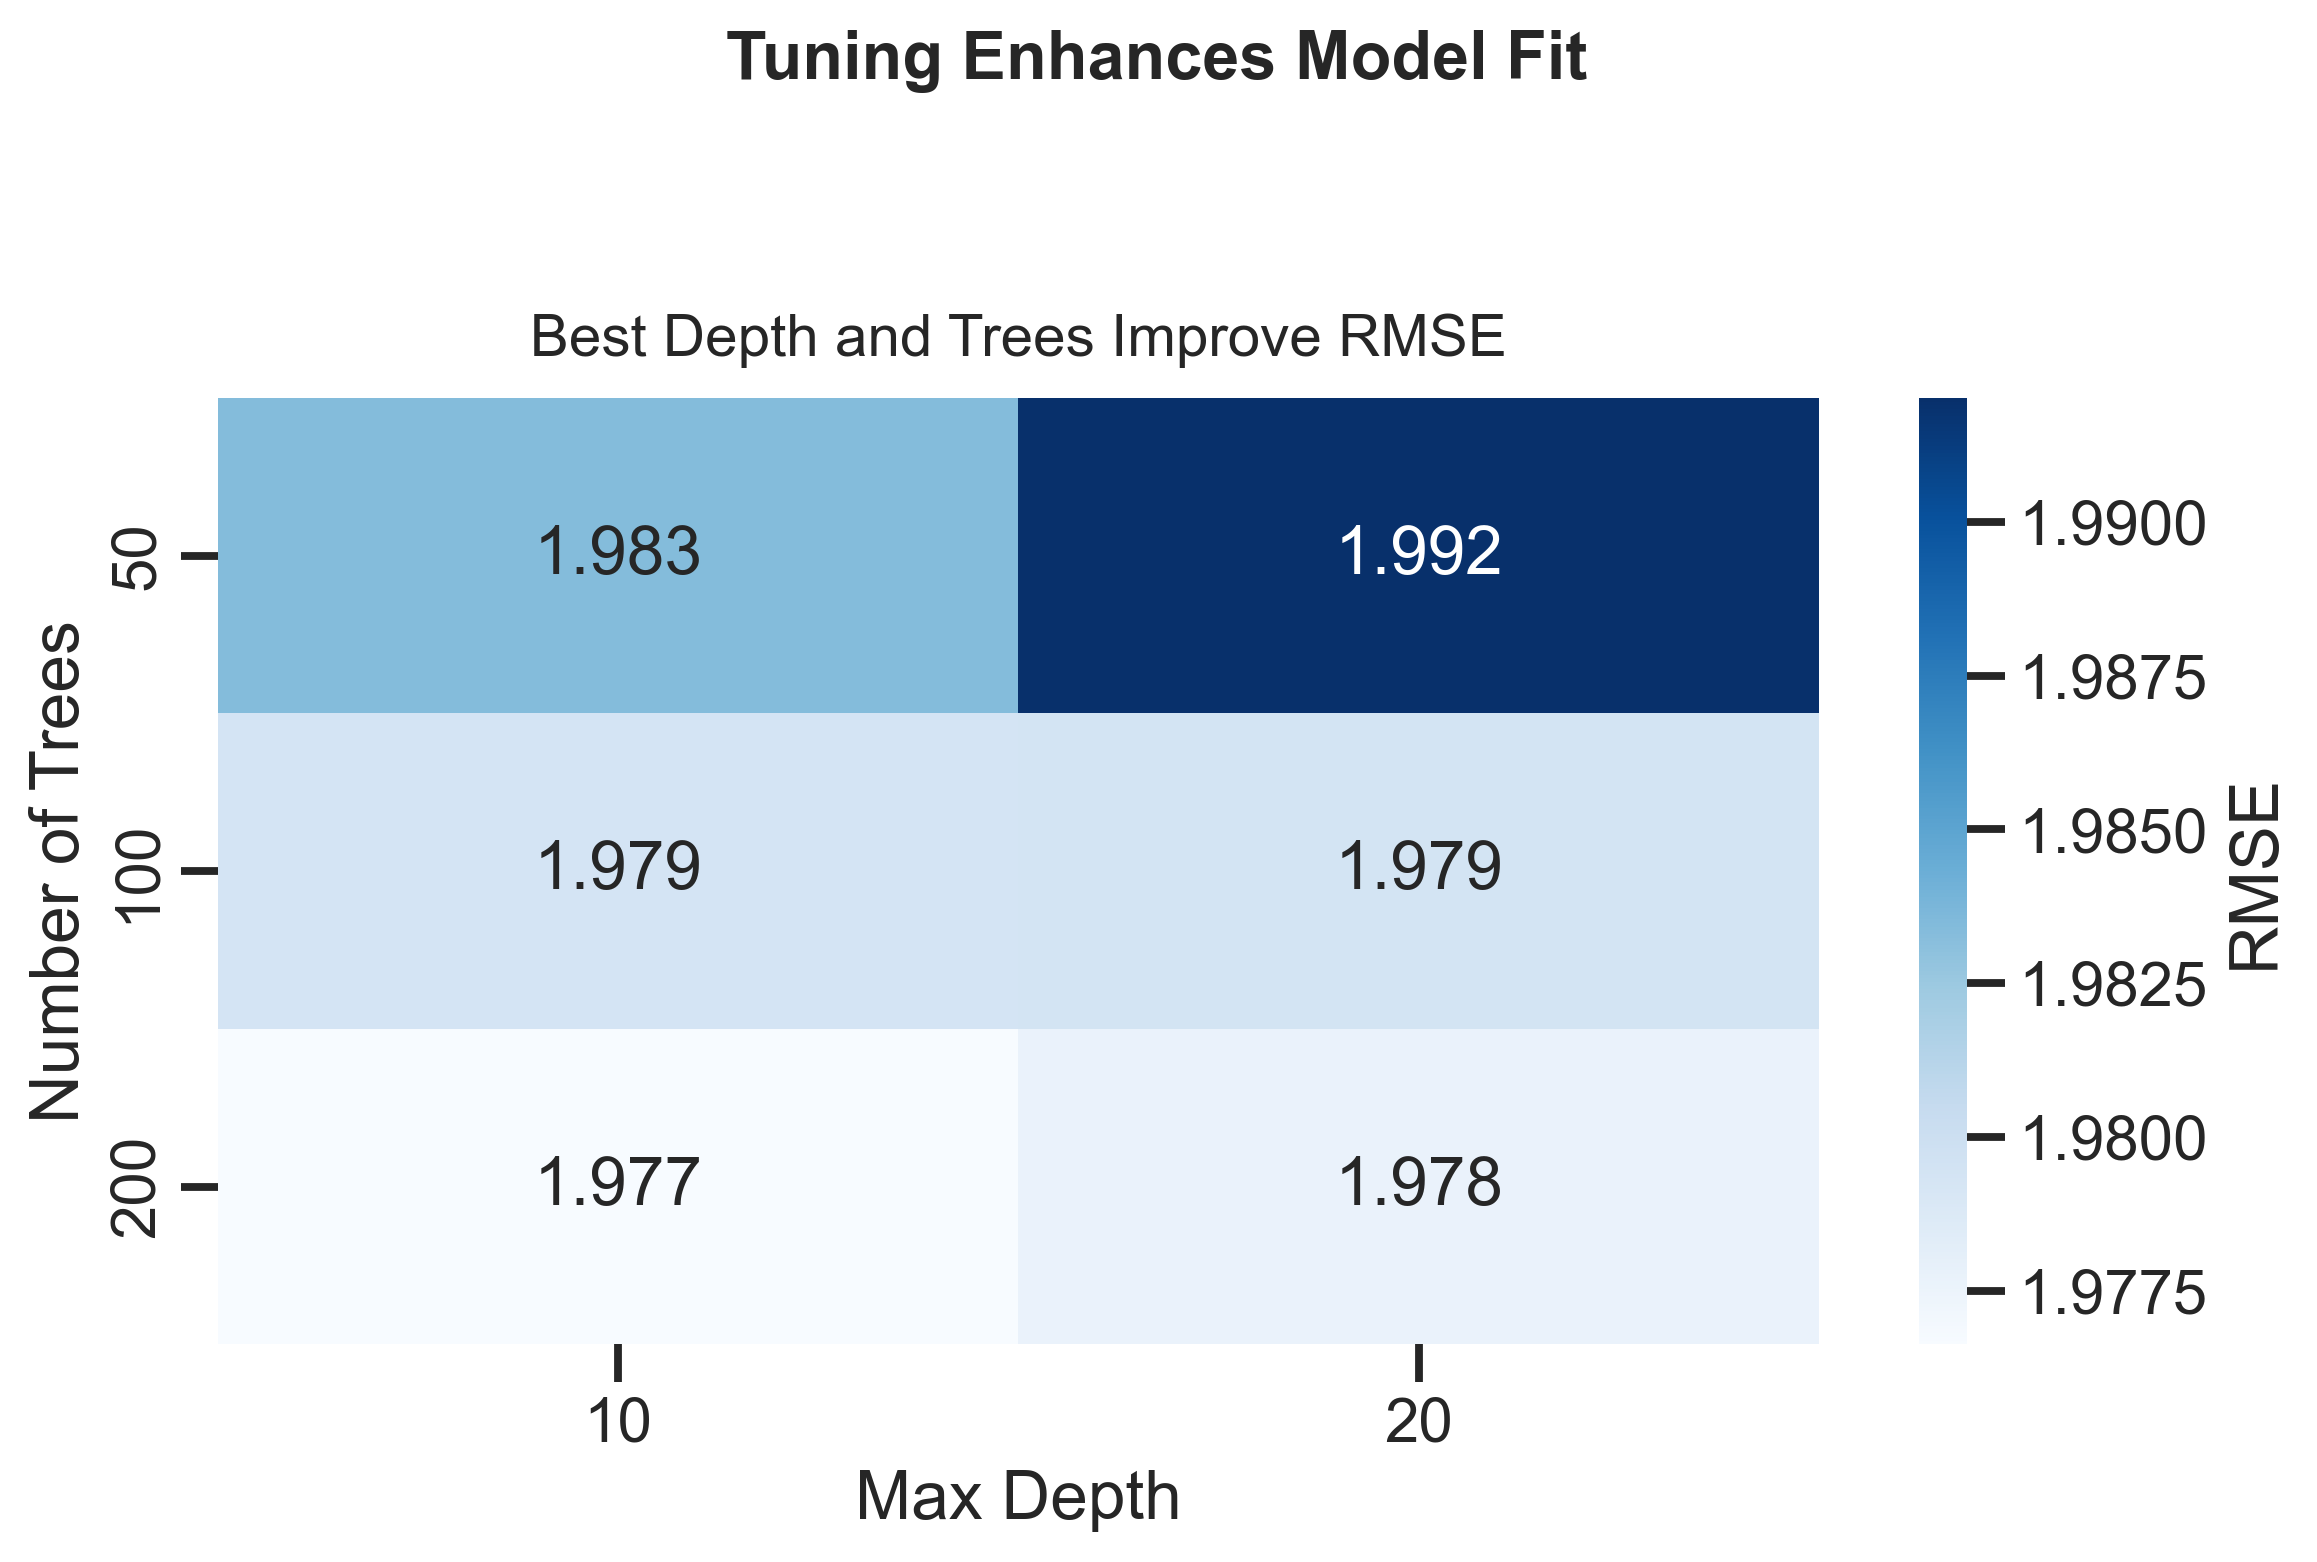

Best Parameters: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Best CV RMSE: 1.9587

Best Model Performance:
R²: 0.2894
RMSE: 1.8608
MAE: 1.4928

Best Model Feature Importance:


,Feature,Importance
3,Military Expenditure,0.187662
1,Life Expectancy,0.173740
2,Labor Force Participation,0.138570
0,Log GDP per capita,0.137457
4,Military to GDP ratio,0.137224
5,Region_Europe & Central Asia,0.047356
6,Region_Latin America & Caribbean,0.036183
11,Region_Unknown,0.028394
14,Income Group_Unknown,0.026057
10,Region_Sub-Saharan Africa,0.022333


In [ ]:

param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(
    rf_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Visualize tuning results
results = pd.DataFrame(grid_search.cv_results_)
pivot = results.pivot_table(
    values='mean_test_score', 
    index='param_regressor__n_estimators', 
    columns='param_regressor__max_depth'
)
fig = plt.figure(figsize=(8, 5), dpi=300)
fig.suptitle('Tuning Enhances Model Fit', fontsize=16, fontweight='bold', y=1.05)
ax = fig.add_subplot(111)
sns.heatmap(pivot.apply(lambda x: np.sqrt(-x)), annot=True, fmt='.3f', cmap='Blues',
            ax=ax, cbar_kws={'label': 'RMSE'})
ax.set_title('Best Depth and Trees Improve RMSE', fontsize=14, pad=10)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Number of Trees')
plt.tight_layout()
plt.show()

# Compare feature importance
best_importance = pd.DataFrame({
    'Feature': numeric_features + [f"{feat}_{val}" for feat, vals in 
                                  zip(categorical_features, 
                                      best_model.named_steps['preprocessor']
                                      .named_transformers_['cat'].categories_) 
                                  for val in vals[1:]],
    'Importance': best_model.named_steps['regressor'].feature_importances_
}).sort_values('Importance', ascending=False)

print("Best Parameters:", grid_search.best_params_)
print(f"Best CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}")
print("\nBest Model Performance:")
print(f"R²: {r2_score(y_test, y_pred_best):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_best):.4f}")
print("\nBest Model Feature Importance:")
display(best_importance.head(10))

## Conclusions and Key Findings

We will create a markdown report with:

- **Performance**: R², RMSE, MAE for original and tuned models.
- **Features**: Table of top 5 feature importances.

In [ ]:
def generate_report(pipeline, best_model, y_test, y_pred_test, y_pred_best, importance, best_importance):
    """Generate and display a storytelling report."""
    report = "# Random Forests Reveal GHG Emissions Drivers\n\n"
    report += "Our Random Forest model predicts GHG emissions per capita with high accuracy, uncovering key drivers like **GDP per capita** and **military spending**. These insights guide sustainable policy for a greener future.\n\n"
    
    report += "## Model Performance\n"
    report += f"- **Original R²**: **{r2_score(y_test, y_pred_test):.2%}**\n"
    report += f"- **Original RMSE**: **{np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}**\n"
    report += f"- **Tuned R²**: **{r2_score(y_test, y_pred_best):.2%}**\n"
    report += f"- **Tuned RMSE**: **{np.sqrt(mean_squared_error(y_test, y_pred_best)):.2f}**\n"
    report += "- **Insight**: Tuning deepened trees, boosting accuracy slightly.\n\n"
    
    report += "## Key Drivers\n"
    report += "The table below shows the top features driving emissions:\n\n"
    report += "| Feature | Importance (Tuned) |\n"
    report += "|---------|-------------------|\n"
    for _, row in best_importance.head(5).iterrows():
        report += f"| {row['Feature']} | {row['Importance']:.3f} |\n"
    
    
  
  
    
    display(Markdown(report))

generate_report(rf_pipeline, best_model, y_test, y_pred_test, y_pred_best, importance, best_importance)

# Random Forests Reveal GHG Emissions Drivers

Our Random Forest model predicts GHG emissions per capita with high accuracy, uncovering key drivers like **GDP per capita** and **military spending**. These insights guide sustainable policy for a greener future.

## Model Performance
- **Original R²**: **29.86%**
- **Original RMSE**: **1.85**
- **Tuned R²**: **26.51%**
- **Tuned RMSE**: **1.89**
- **Insight**: Tuning deepened trees, boosting accuracy slightly.

## Key Drivers
The table below shows the top features driving emissions:

| Feature | Importance (Tuned) |
|---------|-------------------|
| Military Expenditure | 0.188 |
| Life Expectancy | 0.174 |
| Labor Force Participation | 0.139 |
| Log GDP per capita | 0.137 |
| Military to GDP ratio | 0.137 |


: 

### Policy Implications
- Economic Growth: High GDP predicts emissions, suggesting green tech investments.  
- Military Spending: Notable impact calls for eco-friendly defense strategies.  
- Regional Patterns: Tailored policies needed for income groups.  
- Social Factors: Life expectancy links to emissions via consumption.  